## Exploratory Data Analysis - DNA-Binding Proteins

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import Bio
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from scipy.stats import pearsonr
import os

import sys  
sys.path.insert(0, '../scripts')

import eda_utils as eda

%matplotlib inline

Allow multiple outputs from each cell.

In [71]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Load in train and test datasets.

In [72]:
df_train = pd.read_csv("../data/dna_binding/train.csv")
df_test = pd.read_csv("../data/dna_binding/test.csv")

print(f"Train dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")

train_per = round(100*(df_train.shape[0]/(df_train.shape[0]+df_test.shape[0])))
print(f"Train-test split: {train_per}% Train, {100-train_per}% Test")

Train dataset shape: (14189, 4)
Test dataset shape: (2272, 4)
Train-test split: 86% Train, 14% Test


Take a look at the format of the data.

In [73]:
df_test.head()

,code,sequence,label,origin
0,P27204|1,AKKRSRSRKRSASRKRSRSRKRSASKKSSKKHVRKALAAGMKNHLL...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...
1,P53528|1,MVMVVNPLTAGLDDEQREAVLAPRGPVCVLAGAGTGKTRTITHRIA...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...
2,P52684|1,MKDDINQEITFRKLSVFMMFMAKGNIARTAEAMKLSSVSVHRALHT...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...
3,P10961|1,MNNAANTGTTNESNVSDAPRIEPLPSLNDDDIEKILQPNDIFTTDR...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...
4,P06023|1,MAKPAKRIKSAAAAYVPQNRDAVITDIKRIGDLQREASRLETEMND...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...


In [74]:
df_train.head()
df_train.dtypes
print(f"Unique values of label: {df_train.label.unique()}")

,code,sequence,label,origin
0,Q6A8L0,MSGHSKWATTKHKKAAIDAKRGKLFARLIKNIEVAARLGGGDPSGN...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...
1,Q7V7T9,MIGWLQGQKVEAWQQGTRQGVVLACAGVGYEVQIAPRHLSEMEHGQ...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...
2,Q9ZUP2,MARILRNVYSLRSSLFSSELLRRSVVGTSFQLRGFAAKAKKKSKSD...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...
3,Q2JVG1,MKCPRCGKQEIRVLESRSAEGGQSVRRRRECMSCGYRFTTYERIEF...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...
4,Q9K4Q3,MTKADIIEGVYEKVGFSKKESAEIVELVFDTLKETLERGDKIKISG...,1,https://github.com/hfuulgb/PDB-Fusion/tree/mai...


code        object
sequence    object
label        int64
origin      object
dtype: object

Unique values of label: [1 0]


In [75]:
df_train.origin.unique()
df_test.origin.unique()

array(['https://github.com/hfuulgb/PDB-Fusion/tree/main/DNA'],
      dtype=object)

array(['https://github.com/hfuulgb/PDB-Fusion/tree/main/DNA'],
      dtype=object)

All sequences come from the same source, so this column can be safely removed.

#### Checking for Duplicates

In [76]:
df_train = df_train.drop("origin", axis=1)
df_test = df_test.drop("origin", axis=1)

Making sure there are no duplicate proteins.

In [77]:
df_train.sequence.duplicated().sum()
df_test.sequence.duplicated().sum()

173

0

In [78]:
df_train[df_train.sequence.duplicated()].sort_values(by="sequence")

,code,sequence,label
13064,Q0VCF9,MAAPPGEYFSVGSQVSCRTCQEQRLQGEVVAFDYQSKMLALKCPSS...,0
13251,B2S532,MAATSAQHIGLQGHGTSRNDRDRRLVRYWLYAVFAVLIAIVMVGGA...,0
10662,P62200,MADQLTDDQISEFKEAFSLFDKDGDGCITTKELGTVMRSLGQNPTE...,0
12717,B1I8K3,MAEITSAKAMARTVRVSPRKSRLVLDNIRGKSVADAIAILTFTPNK...,0
12578,Q02W29,MAEITSAKATAKTVRVSPRKTRLVIDLIRGKRVADAIAILKFTPTK...,0
...,...,...,...
12991,B5XLG8,MVIDKSIPKATAKRLSLYYRIFKRFHADQVEKASSKQIADAMGIDS...,0
7935,P66686,MVKLAFPRELRLLTPAHFTFVFQQPQRAGTPQITILGRLNSLGHPR...,0
9500,A3DB95,MVYSYSEKKRIRKDFGKRPKVLDIPYLLSIQLDSFKKFTDQDPTGE...,0
8304,Q5PLB4,MYAVFQSGGKQHRVSEGQTVRLEKLDIATGETIEFAEVLMIANGEE...,0


In [79]:
df_train[df_train.sequence.duplicated()].label.value_counts()

0    173
Name: label, dtype: int64

Interestingly enough, all of the duplicated proteins are in the negative class - non-dna-binding proteins. 

In [80]:
# Random example of duplicate
df_train.loc[8304].sequence
df_train.loc[14051].sequence
df_train.loc[8304].code
df_train.loc[14051].code

'MYAVFQSGGKQHRVSEGQTVRLEKLDIATGETIEFAEVLMIANGEEVKIGIPFVDGGVIKAEVVAHGRGEKVKIVKFRRRKHYRKQQGHRQWFTDVKITGISA'

'MYAVFQSGGKQHRVSEGQTVRLEKLDIATGETVEFAEVLMIANGEEVKIGVPFVDGGVIKAEVVAHGRGEKVKIVKFRRRKHYRKQQGHRQWFTDVKITGISA'

'Q5PLB4'

'Q31W63'

In [81]:
df_train[df_train.sequence.duplicated(keep=False)].shape
df_train[df_train.sequence.duplicated(keep=False)].code.nunique()

(312, 3)

312

Another interesting discovery: the duplicates all have different codes, despite having identical sequences.

#### Remove duplicates

In [82]:
df_train = df_train.drop_duplicates(["sequence"])
df_train.shape

(14016, 3)

Check for distribution of classes to identify potential imbalances.

In [83]:
df_train.label.value_counts()
df_test.label.value_counts()
print("Both train and test datasets are almost perfectly balanced between the positive and negative class")

1    7129
0    6887
Name: label, dtype: int64

1    1153
0    1119
Name: label, dtype: int64

Both train and test datasets are almost perfectly balanced between the positive and negative class


Visualizing the distribution of the lengths of sequences in each dataset.

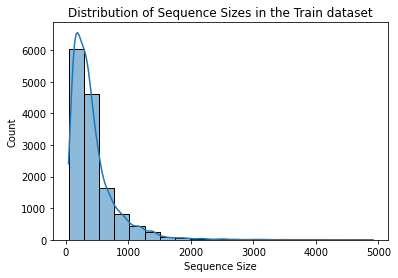

In [84]:
sns.histplot(df_train.sequence.str.len(), bins=20, kde=True);
plt.xlabel("Sequence Size");
plt.title('Distribution of Sequence Sizes in the Train dataset');

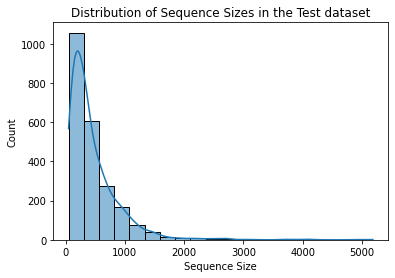

In [85]:
sns.histplot(df_test.sequence.str.len(), bins=20, kde=True);
plt.xlabel("Sequence Size");
plt.title('Distribution of Sequence Sizes in the Test dataset');

In [86]:
train_seq_sizes = df_train.sequence.str.len()
test_seq_sizes = df_test.sequence.str.len()

print(f"Train dataset - mean of sequence sizes: {train_seq_sizes.mean()}")
print(f"Test dataset - mean of sequence sizes: {test_seq_sizes.mean()}")

print(f"Train dataset - smallest sequence size: {train_seq_sizes.min()}")
print(f"Test dataset - smallest sequence size: {test_seq_sizes.min()}")

print(f"Train dataset - largest sequence size: {train_seq_sizes.max()}")
print(f"Test dataset - largest sequence size: {test_seq_sizes.max()}")

Train dataset - mean of sequence sizes: 427.5094891552511
Test dataset - mean of sequence sizes: 459.9806338028169
Train dataset - smallest sequence size: 47
Test dataset - smallest sequence size: 51
Train dataset - largest sequence size: 4911
Test dataset - largest sequence size: 5183


## Feature Engineering - Protein Features

#### Checking set of amino acids present in dataset

In [87]:
amino_acids = set()
for protein in df_train.sequence:
    for acid in protein:
        amino_acids.add(acid)

for protein in df_test.sequence:
    for acid in protein:
        amino_acids.add(acid)

print(amino_acids)
print(len(amino_acids))

{'U', 'S', 'F', 'W', 'v', 'Q', 'N', 'D', 'R', 'I', 'Y', 'A', 'H', 'P', 'X', 'G', 'L', 'O', 'C', 'E', 'M', 'V', 'B', 'T', 'K'}
25


This dataset has 4 extra amino acid symbols besides the 20 natural amino acids. 

'X' denotes an unknown amino acid;

'B' denotes Asparagine ('N') or Aspartic Acid ('D');

'O' denotes Pyrrolysine;

and 'U' denotes Selenocysteine.

We have to decide how to handle this in our feature engineering. 

The 1 extra amino acid counted in the amino acid set is the lowercase 'v', which should be uppercase to denote Valine, which is already listed, so we have to find the instance where that typo happened and make it an uppercase 'V'.

#### Identifying and Counting number of occurrences of X, B, O, U, and the typo v in Train and Test Sets

In [88]:
extra_acids = ['X', 'B', 'O', 'U', 'v']

tr_count_dict = dict.fromkeys(extra_acids, 0)
tr_idx_dict = {key: [] for key in extra_acids}

for idx, prot in zip(df_train.index, df_train.sequence):
    for key in tr_count_dict.keys():
        count = prot.count(key)
        tr_count_dict[key] = tr_count_dict.get(key) + count
        if count != 0:
            tr_idx_dict[key].append(idx)

for key in tr_count_dict.keys():
    print(f"Total amount of {key}'s in Train set: {tr_count_dict.get(key)}")
    print(f"Indexes of sequences with {key}'s: {tr_idx_dict.get(key)} \n")

Total amount of X's in Train set: 116
Indexes of sequences with X's: [416, 1490, 1764, 2294, 2393, 2555, 2868, 2874, 2881, 3185, 3485, 3532, 3690, 3738, 4726, 4966, 5896, 6268, 6696, 6818, 6825, 6827, 7931, 8169, 8240, 8838, 9006, 9689, 11449, 11643, 11889, 11934, 12278, 12302, 12761, 13452, 13456, 13489, 13985] 

Total amount of B's in Train set: 1
Indexes of sequences with B's: [11889] 

Total amount of O's in Train set: 1
Indexes of sequences with O's: [10937] 

Total amount of U's in Train set: 3
Indexes of sequences with U's: [7738, 8310, 8406] 

Total amount of v's in Train set: 0
Indexes of sequences with v's: [] 



In [89]:
t_count_dict = dict.fromkeys(extra_acids, 0)
t_idx_dict = {key: [] for key in extra_acids}

for idx, prot in zip(df_train.index, df_test.sequence):
    for key in t_count_dict.keys():
        count = 0
        count = prot.count(key)
        t_count_dict[key] = t_count_dict.get(key) + count
        if count != 0:
            t_idx_dict[key].append(idx)

for key in t_count_dict.keys():
    print(f"Total amount of {key}'s in Test set: {t_count_dict.get(key)}")
    print(f"Indexes of sequences with {key}'s: {t_idx_dict.get(key)} \n")

Total amount of X's in Test set: 0
Indexes of sequences with X's: [] 

Total amount of B's in Test set: 0
Indexes of sequences with B's: [] 

Total amount of O's in Test set: 0
Indexes of sequences with O's: [] 

Total amount of U's in Test set: 0
Indexes of sequences with U's: [] 

Total amount of v's in Test set: 1
Indexes of sequences with v's: [2195] 



It looks like X occurs the most often out of the 4 extra symbols, the train set is the only one that contains these 4 extra symbols, and the lowercase v typo only occurs once, in the test set.

In [90]:
# Replace lowercase v with uppercase V
df_test.sequence = df_test.sequence.str.upper()

In [93]:
# Add protein features as columns
df_train = eda.add_protein_features(df_train, "sequence")
df_test = eda.add_protein_features(df_test, "sequence")

In [95]:
df_train.head()

,code,sequence,label,amino_acid_count,amino_acid_percent,molecular_weight,instability_index,flexibility,gravy,aromaticity,isoelectric_point,charge_at_pH,helix_frac,turn_frac,sheet_frac,molar_extinction_coefficient
0,Q6A8L0,MSGHSKWATTKHKKAAIDAKRGKLFARLIKNIEVAARLGGGDPSGN...,1,"{'A': 30, 'C': 1, 'D': 25, 'E': 25, 'F': 6, 'G...","{'A': 11.363636363636363, 'C': 0.3787878787878...",28737.6395,33.052652,1.008563,-0.456818,0.053030,4.699812,-16.685650,0.265152,0.200758,0.276515,15930.0
1,Q7V7T9,MIGWLQGQKVEAWQQGTRQGVVLACAGVGYEVQIAPRHLSEMEHGQ...,1,"{'A': 21, 'C': 4, 'D': 13, 'E': 18, 'F': 5, 'G...","{'A': 9.333333333333334, 'C': 1.77777777777777...",24694.7574,48.138667,0.999260,-0.182667,0.053333,5.078530,-9.621981,0.288889,0.204444,0.311111,30605.0
2,Q9ZUP2,MARILRNVYSLRSSLFSSELLRRSVVGTSFQLRGFAAKAKKKSKSD...,1,"{'A': 39, 'C': 4, 'D': 19, 'E': 32, 'F': 17, '...","{'A': 9.069767441860465, 'C': 0.93023255813953...",46159.3211,43.260047,1.006296,-0.125581,0.053488,8.167580,1.347800,0.290698,0.248837,0.293023,9065.0
3,Q2JVG1,MKCPRCGKQEIRVLESRSAEGGQSVRRRRECMSCGYRFTTYERIEF...,1,"{'A': 5, 'C': 5, 'D': 7, 'E': 25, 'F': 6, 'G':...","{'A': 2.5, 'C': 2.5, 'D': 3.5000000000000004, ...",23317.3888,77.657500,1.006989,-0.695000,0.055000,7.596156,0.194486,0.270000,0.205000,0.275000,11585.0
4,Q9K4Q3,MTKADIIEGVYEKVGFSKKESAEIVELVFDTLKETLERGDKIKISG...,1,"{'A': 14, 'C': 0, 'D': 9, 'E': 20, 'F': 6, 'G'...","{'A': 10.852713178294573, 'C': 0.0, 'D': 6.976...",14299.7698,34.576744,1.017019,-0.720155,0.054264,4.762960,-9.682345,0.224806,0.186047,0.333333,1490.0


In [96]:
df_train.dtypes

code                             object
sequence                         object
label                             int64
amino_acid_count                 object
amino_acid_percent               object
molecular_weight                float64
instability_index               float64
flexibility                     float64
gravy                           float64
aromaticity                     float64
isoelectric_point               float64
charge_at_pH                    float64
helix_frac                      float64
turn_frac                       float64
sheet_frac                      float64
molar_extinction_coefficient    float64
dtype: object

### Amino Acid Frequencies/Composition

#### Get average amino acid content of sequences

In [97]:
print(amino_acids)

{'U', 'S', 'F', 'W', 'v', 'Q', 'N', 'D', 'R', 'I', 'Y', 'A', 'H', 'P', 'X', 'G', 'L', 'O', 'C', 'E', 'M', 'V', 'B', 'T', 'K'}


In [98]:
dbp_avg_acids = eda.get_avg_amino_acid_count(df_train[df_train.label==1], amino_acids)
non_dbp_avg_acids = eda.get_avg_amino_acid_count(df_train[df_train.label==0], amino_acids)

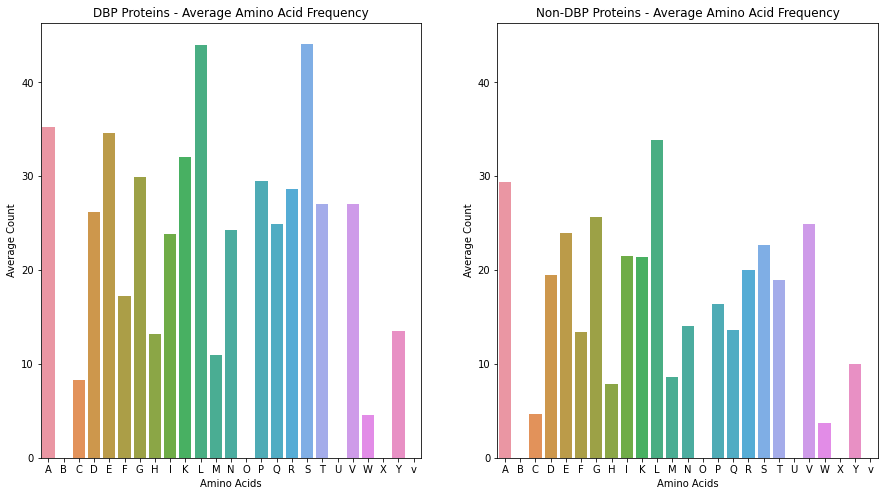

In [99]:
plt.figure(figsize=(15,8))

ax1 = plt.subplot(121)
sns.barplot(x = sorted(dbp_avg_acids.keys()), 
            y = [dbp_avg_acids.get(key) for key in sorted(dbp_avg_acids.keys())]).set(
                title='DBP Proteins - Average Amino Acid Frequency');
ax1.set(xlabel='Amino Acids', ylabel='Average Count');

ax2 = plt.subplot(122, sharey=ax1)
sns.barplot(x = sorted(non_dbp_avg_acids.keys()), 
            y = [non_dbp_avg_acids.get(key) for key in sorted(non_dbp_avg_acids.keys())]).set(
                title='Non-DBP Proteins - Average Amino Acid Frequency');
ax2.set(xlabel='Amino Acids', ylabel='Average Count');

In [100]:
pearsonr([dbp_avg_acids.get(key) for key in sorted(dbp_avg_acids.keys())],
            [non_dbp_avg_acids.get(key) for key in sorted(non_dbp_avg_acids.keys())])[0]

0.9534065532306623

As seen in both the barplots of and correlation between the amino acid average percentages per sequence of dbp and non-dbp proteins, there is very little difference between the two, so this feature likely has very little predictive power for classifying DBPs and non-DBPs. 

In addition, the proteins chosen for this dataset may not be indicative of general trends in amino acid frequency, so we have to take care to be aware of this assumption if using this feature in our models.

#### Get average percentage of amino acids for each sequence

In [101]:
# Get average percentage of frequency of each amino acid over all ACP and non-ACP sequences
dbp_avg_acids_percent = eda.get_avg_amino_acid_percent(df_train[df_train.label==1], amino_acids)
non_dbp_avg_acids_percent = eda.get_avg_amino_acid_percent(df_train[df_train.label==0], amino_acids)

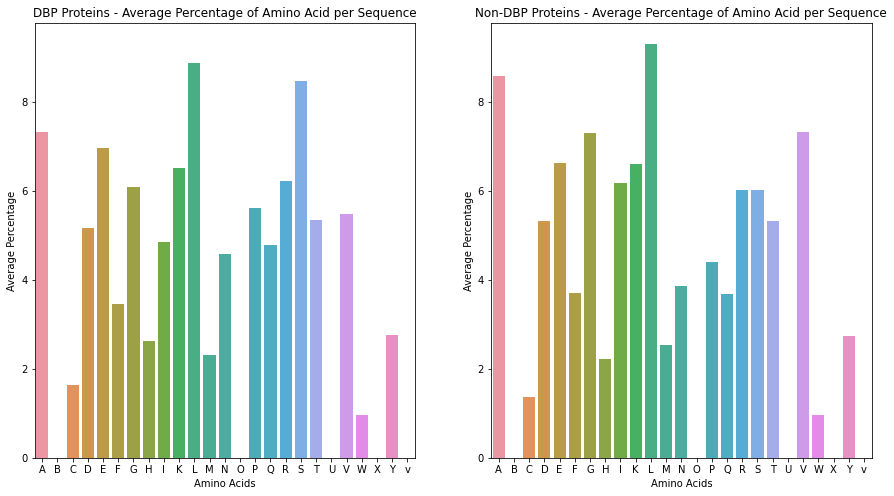

In [102]:
plt.figure(figsize=(15,8))
ax1 = plt.subplot(121)
sns.barplot(x = sorted(dbp_avg_acids_percent.keys()), 
            y = [dbp_avg_acids_percent.get(key) for key in sorted(dbp_avg_acids_percent.keys())]).set(
                title='DBP Proteins - Average Percentage of Amino Acid per Sequence');
ax1.set(xlabel='Amino Acids', ylabel='Average Percentage');
ax2 = plt.subplot(122, sharey=ax1)
sns.barplot(x = sorted(non_dbp_avg_acids_percent.keys()), 
            y = [non_dbp_avg_acids_percent.get(key) for key in sorted(non_dbp_avg_acids_percent.keys())]).set(
                title='Non-DBP Proteins - Average Percentage of Amino Acid per Sequence');
ax2.set(xlabel='Amino Acids', ylabel='Average Percentage');


In [103]:
pearsonr([dbp_avg_acids_percent.get(key) for key in sorted(dbp_avg_acids_percent.keys())],
            [non_dbp_avg_acids_percent.get(key) for key in sorted(non_dbp_avg_acids_percent.keys())])[0]

0.9545182511502036

Just like with the barplots and correlation for the amino_acid_count feature, there is significant correlation between amino_acid_avg percentages of DBP and non-DBP sequences, and this feature likely has little predictive power.

### All other Protein Features

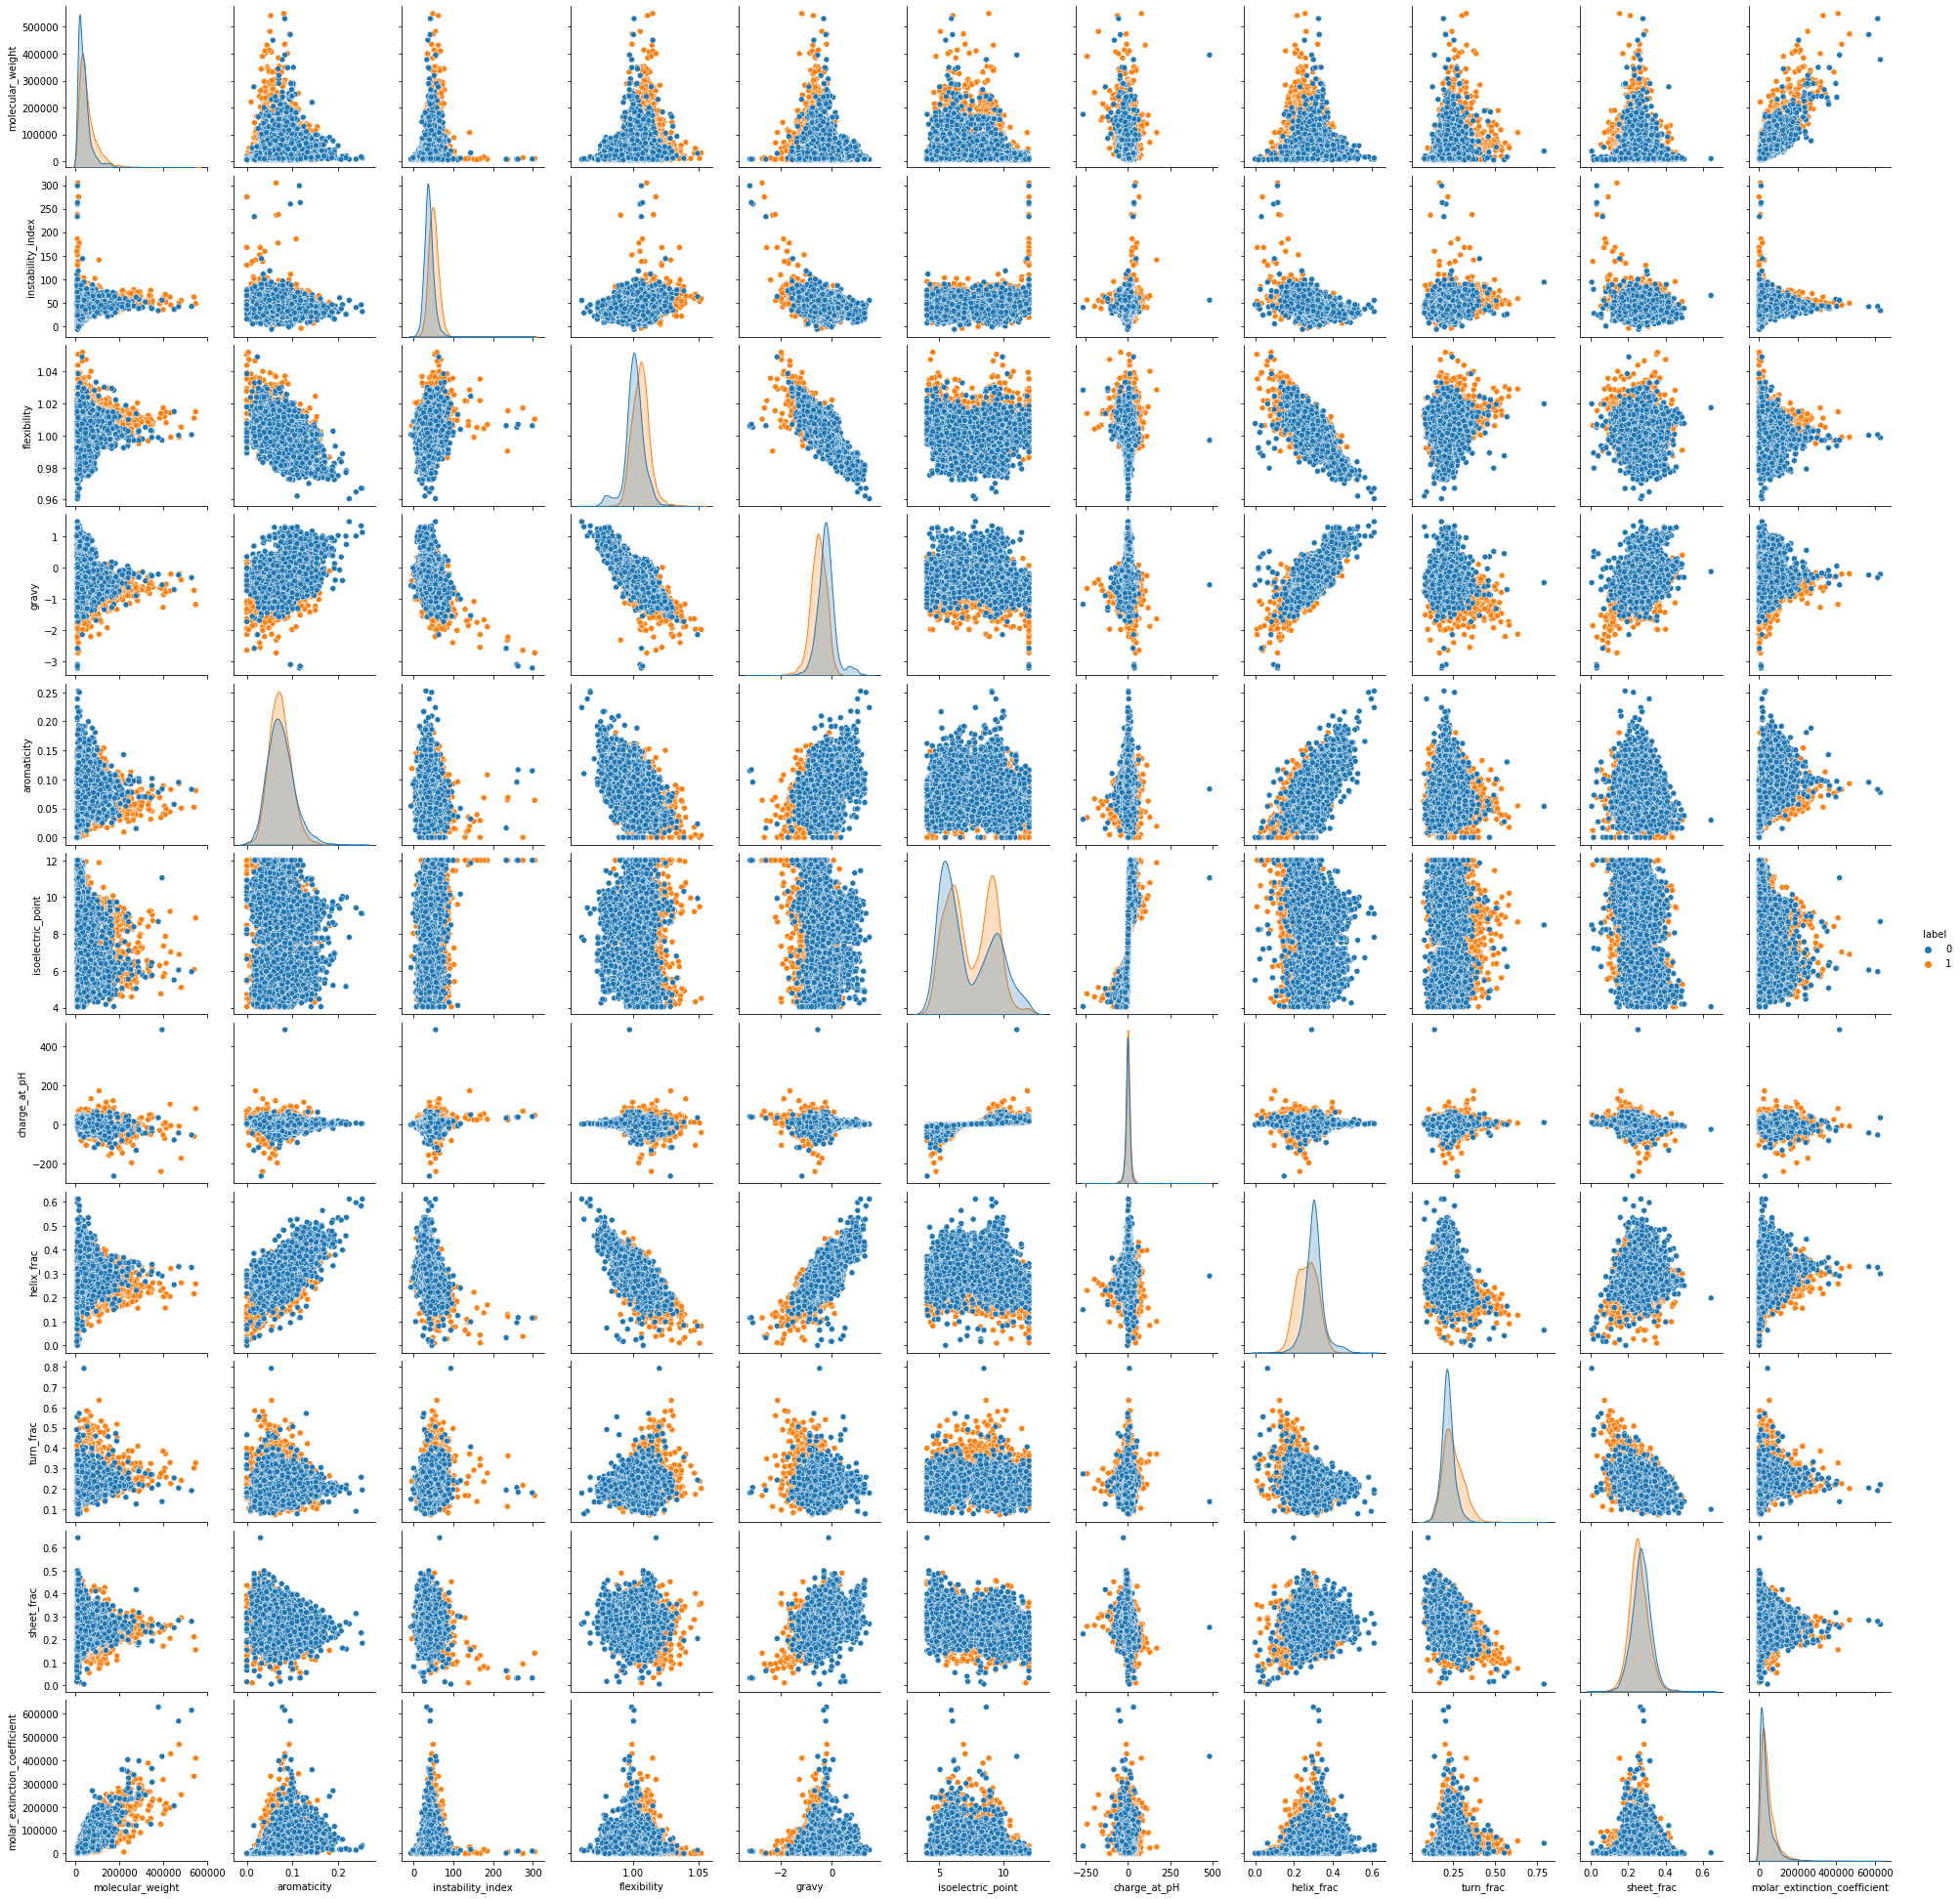

In [104]:
prot_features=["molecular_weight", "aromaticity", "instability_index", "flexibility", "gravy", 
               "isoelectric_point", "charge_at_pH", "helix_frac", "turn_frac", "sheet_frac",
               "molar_extinction_coefficient"]
sns.pairplot(data=df_train, x_vars=prot_features, hue="label")

There seems to be a significant amount of separation between DBPs and non-DBPs with regards to these features, although the two groups are not fully separated by any of these features. It is possible however that a classifier that uses all of these features might perform well at the DBP classification task.

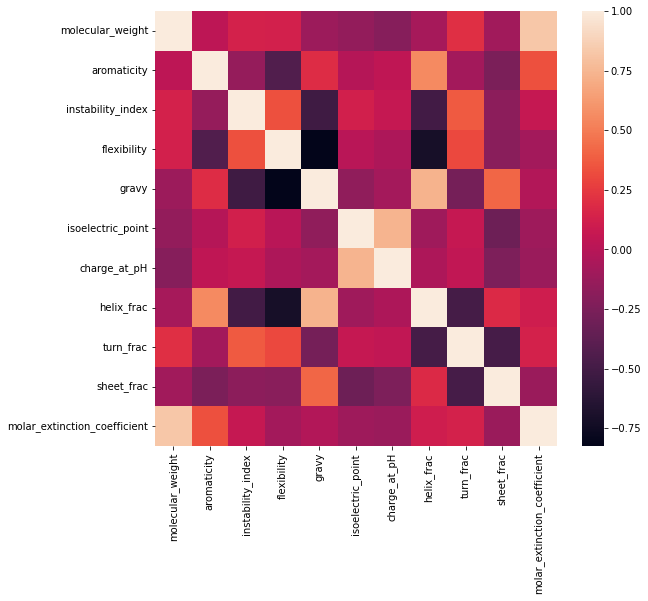

In [106]:
plt.figure(figsize=(9,8))
sns.heatmap(data=df_train[prot_features].corr());

It looks like the most highly correlated features are `molar_extinction_coefficient` and `molecular_weight`.

The `charge_at_pH` and `isoelectric_point` features are also highly correlated, although to a lesser degree. This makes sense, as both refer to a pH value, the first being the charge of the protein at the average human body pH (7.4), and the second as the pH at which no net migration takes place in an electric field.

The `helix_frac` and `gravy` are also similarly significantly correlated, as are `helix_frac` and `flexibility`, although these two are highly negatively correlated. 

Since all these features are highly correlated, they are all potential candidates for removal during modelling in order to avoid multicollinearity, after checking the variance inflation factor to quantify the severity of multicollinearity. 

In [107]:
df_train.to_csv("../data/dna_binding/train_expanded.csv", index=False)
df_test.to_csv("../data/dna_binding/test_expanded.csv", index=False)

## Alignment

In [108]:
sequences = df_train.copy()
sequences.drop(df_train.columns.difference(["sequence", "label"]), axis=1, inplace=True)
sequences.head()

,sequence,label
0,MSGHSKWATTKHKKAAIDAKRGKLFARLIKNIEVAARLGGGDPSGN...,1
1,MIGWLQGQKVEAWQQGTRQGVVLACAGVGYEVQIAPRHLSEMEHGQ...,1
2,MARILRNVYSLRSSLFSSELLRRSVVGTSFQLRGFAAKAKKKSKSD...,1
3,MKCPRCGKQEIRVLESRSAEGGQSVRRRRECMSCGYRFTTYERIEF...,1
4,MTKADIIEGVYEKVGFSKKESAEIVELVFDTLKETLERGDKIKISG...,1


In [109]:
# Demonstrate pairwise alignment 
for idx, prot_1 in enumerate(sequences.sequence[:3]):
    sim_seq = None
    max_score = 0
    alignment = None
    for prot_2 in sequences.sequence.drop(idx):
        alignments = pairwise2.align.globalxx(prot_1, prot_2)
        score = int(format_alignment(*alignments[0]).split("Score=")[1].rstrip())
        if score > max_score:
            max_score = score
            sim_seq = prot_2
            alignment = format_alignment(*alignments[0])
    print(max_score, sim_seq)
    print(alignment)

262 MGDSLENPDTSVDPIVNLSIANYDAFANYLRKAVTILLPEDDVVPASLNDALDDPVNQDTIRKFLSDPQVQALYVQRNCIKEDDSEQPAEGEDEKEQVTYQISNDVHFTNSRMASLACIKRGLVVEADKSIHSQLRLINFSDGSPYETLHAFISKSLAPYFKSYVKESGRADRDGDKMAPSVEKKLAELEMGLLHLQQNIDIPEITLTAHQTVNNVIRKCAEENRKAKVADFGDKVEDSSFLNLLQNGVNRWIAEIKKVTKLNRDPGSGTALQEISFWLNLERALYRIQEKRESPEVALTLDILKHGKRFHATVSFDTDTGLKQALATVADYNPLMKDFPINDLLSATELEKIRPAVQQIFAHLRKVRNTKYPIQRCLKLIEAISRDLSQQLLKVLGTRRLMHIPFDEFERVMNQCFEIFSCWDDEYDKLQGLLRDIVKKKRDEHLKMVWRVSPAHKKLQTRMEHMRKFRRQHEQLRTVILRVLRPTKPAVGDDGNVVETKQPYSLDAADANAIEEVNLAYENVKEVDCLDITKEGSEAWEAAVKRYEEKIDRVETRITAHLRDQLGTAKNANEMFRIFSRFNALFVRPHIRGAIREYQTQLIQRVKDDIEALHEKFKVQYPQSKSCRLSSVRDLPPVAGSIIWARQIDNQLTMYLKRVEDVLGKGWETHIEGQKLKADGDSFRAKLSISDVFHEWARKVQERNFGSTGRIFTIESTRSRIGRGNVLRLRVNFLPEIITLAKEVRNIKNLGFRVPLTIVNKAHQANQIYPYAISLIESVRTYERTLEKIEDRASIVPLVAGLRKDVLNLVSEGIGLIWESYKLDPYVIRLSECVTQFQEKVDDLLVVEEQLDVDVRSLETCPYSAATFVEILSKIQHAVDDLSLRQYSNLSVWVTRLDEEVEKKLALRLQAGIQAWTEALTGNKKEVDTSMDTDAPAQPTHKLGGDPQIQNAVHEIRITNQQMYLYPSIEEARFQIMQQFFAWQAIVTSQVRLQST

### Investigating cross-similarity scores

In [120]:
# Taking a subset of the train and test sets to compute cross-similarity scores in less time
train_small = df_train.sample(1000, random_state=42) 
test_small = df_test.sample(500, random_state=42)

In [121]:
cross_df_tr = pd.DataFrame(index=train_small.sequence, columns=train_small.sequence)
cross_df_tr.head()

cross_df_t = pd.DataFrame(index=test_small.sequence, columns=test_small.sequence)
cross_df_t.head()

sequence,MIKLRMPAGGERYIDGKSVYKLYLMIKQHMNGKYDVIKYNWCMRVSDAAYQKRRDKYFFQKLSEKYKLKELALIFISNLVANQDAWIGDISDADALVFYREYIGRLKQIKFKFEEDIRNIYYFSKKVEVSAFKEIFEYNPKVQSSYIFKLLQSNIISFETFILLDSFLNIIDKHDEQTDNLVWNNYSIKLKAYRKILNIDSQKAKNVFIETVKSCKY,MATNFLAHEKIWFDKFKYDDAERRFYEQMNGPVAGASRQENGASVILRDIARARENIQKSLAGSSGPGASSGTSGDHGELVVRIASLEVENQSLRGVVQELQQAISKLEARLNVLEKSSPGHRATAPQTQHVSPMRQVEPPAKKPATPAEDDEDDDIDLFGSDNEEEDKEAAQLREERLRQYAEKKAKKPALVAKSSILLDVKPWDDETDMAQLEACVRSIQLDGLVWGASKLVPVGYGIRKLQIQCVVEDDKVGTDLLEEEITKFEEHVQSVDIAAFNKI,MNLLNLFNPLQTAGMEEEFDAIKIGIASPETIRSWSYGEVKKPETINYRTFKPERDGLFCAKIFGPVKDYECLCGKYKRLKFKGVTCEKCGVEVTLSKVRRERMGHIELAAPVAHIWFLKSLPSRLGMVLNMTLRDIERVLYFEAFVVTDPGMTPLQRRQLLTEDDYYNKLDEYGDDFDAKMGAEGIRELLRTLDVAGEIEILRQELESTGSDTKIKKIAKRLKVLEAFHRSGMKLEWMIMDVLPVLPPDLRPLVPLDGGRFATSDLNDLYRRVINRNNRLKRLLELHAPDIIVRNEKRMLQEAVDSLLDNGRRGKAMTGANKRPLKSLADMIKGKGGRFRQNLLGKRVDYSGRSVITVGPYLRLHQCGLPKKMALELFKPFIFHKLEKQGLASTVKAAKKLVEQEVPEVWDILEEVIREHPIMLNRAPTLHRLGIQAFEPILIEGKAIQLHPLVCAAFNADFDGDQMAVHVPLSLEAQMEARTLMLASNNVLSPANGEPIIVPSQDIVLGLYYMTRDRINAKGEGSLFADVKEVHRAYHTKQVELGTKITVRLREWVKNEAGEFEPVVNRYETTVGRALLSEILPKGLPFEYVNKALKKKEISKLINASFRLCGLRDTVIFADHLMYTGFGFAAKGGISIAVDDMEIPKEKAALLAEANAEVKEIEDQYRQGLVTNGERYNKVVDIWGRAGDKIAKAMMDNLSKQKVIDRDGNEVDQESFNSIYMMADSGARGSAAQIKQLSGMRGLMAKPDGSIIETPITSNFREGLTVLQYFIATHGARKGLADTALKTANSGYLTRRLVDVTQDLVVVEDDCGTSDGFVMKAVVQGGDVIEALRDRILGRVTASDVVDPSSGETLVEAGTLLTEKLVDMIDQSGVDEVKVRTPITCKTRHGLCAHCYGRDLARGKLVNAGEAVGVIAAQSIGEPGTQLTMRTFHIGGAASRAAAASQVEAKSNGTARFSSQMRYVANNKGELVVIGRSCEVVIHDDIGRERERHKVPYGAILLVQDGMAIKAGQTLATWDPHTRPMITEHAGMVKFENMEEGVTVAKQTDDVTGLSALVVIDGKRRSSSASKLLRPTVKLLDENGVEICIPGTSTPVSMAFPVGAVITVREGQEIGKGDVLARIPQASSKTRDITGGLPRVAELFEARVPKDAGMLAEITGTVSFGKETKGKQRLIITDVDGVAYETLISKEKQILVHDGQVVNRGETIVDGAVDPHDILRLQGIEALARYIVQEVQEVYRLQGVKISDKHIEVIIRQMLRRVNIADAGETGFITGEQVERGDMMAANEKALEEGKEPARYENILLGITKASLSTDSFISAASFQETTRVLTEAAIMGKQDELRGLKENVIVGRLIPAGTGLTYHRSRHQQWQGVEQETAETQVTDE,MILTRIILHNYRNIEAAELCPEENFNLLCGDNAQGKTNTLEAIYLLGHFKSFRRGRNEELIGSADRHTRVQGEFLRDGLRETVSITITGDKKNIEINGKRPRQSNEMFGRFPSVLFAPEEVSLPKGFPAGRRALLDRALCQTRPSFLDHARAYQRCLRQRNILLKSGAAAPIVLPWTEELIQTGAMVRLARRRYLDRLLPLLRDIYREICSGRESVNLVYPSESDNLSDLKEELRSNLEREQSRETKYGMTMVGPHRDDPVFMVDDRVLGLYGSQGQQRSFILAFKTAQIIDLEKETGYTPLLLLDDMTSELDRKRQDYFFRFLHQRQGQVFITCTELSPLQNAGFNRMRTFRVREGKLCDYQ,MIQGSAPGGLSRLPSNKLTCEICGMVCIGPNVLMVHKRSHTGERPFQCNQCGASFTQKGNLLRHVKLHTDEKPFKCSLCSYACRRRDALMGHIRTHSVGKPYKCNFCSRSYKQRSSLEEHQERCPGFHQGLPSSHLAENAFSKYGTTTERADWEHVIRPGQEPPLLDDSALLPTDVRLGLDPAIETQLEPGFDKLSNQDRFSNNFQAKRKSSTPQKVFGQKRMQLELSDIHYDQATSSLSERLHEVPGPVCAQTLEPSASVFLNTPSPVTRSAGQALEATRRLESESPGLPSDIGSIVRPVYSQSVDNRFQHDSPLSTSRSGLSQQPGRHHPSPGILGGSLGGICGRPAEAVGDSRPVNMPPGRGATSSPSNSCPDSTDTESSHEERSHHRTGSGSSTSRPNGSTGRPHRPEMHQDNGRLNRVSGASDSSSLPTYNVSGSDGEALRTYPCHHCGLLFLDHVMYTLHMGCHGFRDPFECNVCGYRSRDRYEFSSHIIRGEHLPTAE,MSAHRIRARRITRRNVPLAERCSFRIGGAAQFWAEPRSCTQLRALIEEAQRARIPLSLIGGGSNVLIADEGVPGLMLSLRRFRSLHTQTQRDGSVLVHAGAGLPVAALLAFCAHHALRGLETFAGLPGSVGGAAYMNARCYGRAIADCFHSARTLVLHPVRSRAKELPEVRKNAQDKRGECLGLDGGPFTCSSFQTVFARAGDWGYKRSPFQSPHGVELHAGRRLILSLCVRLTPGNPAQIRKHMQEKIADRISKGQFRFPSAGSAFKNNPAFGKPSGILIEEAGLRGTSCGAAQVAPWHGNLIINTGNATAHQVRTLLRVVRQRVFETHGVWLEREIIFSGESVRMTSSSRDS,MIARTKIICTIGPATNTPEMLEKLLDAGMNVARLNFSHGTHESHGRTIAILKELREKRQVPLAIMLDTKGPEIRLGQVESPIKVQPGDRLTLVSKEILGSKESGVTLYPSCVFPYVRERAPVLIDDGYIQAVVVNAQEHMVEIEFQNSGEIKSNKSLSIKDIDVALPFMTEKDIADLKFGVEQELDLIAASFVRCNEDIDSMRKVLESFGRPNMPIIAKIENHLGVQNFQEIARAADGIMIARGDLGIELSIVEVPGLQKFMARASRETGRFCITATQMLESMIRNPLPTRAEVSDVANAIYDGTSAVMLSGETASGAHPVHAVKTMRSIIQETEKTFDYHAFFQLNDKNSALKVSPYLEAIGFSGIQIAEKASAKAIIVYTQTGGSPMFLSKYRPYLPIIAVTPNRNVYYRLAVEWGVYPMLTLESNRTVWRHQACVYGVEKGILSNYDKILVFSRGAGMQDTNNLTLTTVHDALSPSLDEIVP,MSENGSVDEIKVEEFNNEAGQTVESGELSEDNELNRKTGRNLNLIKCEECGLICAGQSHYNVHIRSHTGERPFKCHICGVAFTQKGNLRRHYKIHSDEKPFQCPICSYRCRRRDALNGHMRIHSDMRPYRCSYCARSYKSRQSMKEHEYQCPYKSDPVQPTPPGSEGFPFQNEAVMRNPLALPGPRPSTSQPAPVLSQLGQLGARPPPYPPANINELLALRARLMAPGAQHAPPPPQIRPGLPGFFGNAIPQMPPTTLQQPFNAESHRSAVGMGGTHALALHIRRLLANAVQQNQQPGGLRNSLEKPSLSEATPSSHSSHSSAEDSGQVNKFSPTESKVKPTDINQNVAKILANMVQPHPQLEDVPLPDSRKRPHSFESEPTPKRMRS

sequence,METEQPEETFPNTETNGEFGKRPAEDMEEEQAFKRSRNTDEMVELRILLQSKNAGAVIGKGGKNIKALRTDYNASVSVPDSSGPERILSISADIETIGEILKKIIPTLEEGLQLPSPTATSQLPLESDAVECLNYQHYKGSDFDCELRLLIHQSLAGGIIGVKGAKIKELRENTQTTIKLFQECCPHSTDRVVLIGGKPDRVVECIKIILDLISESPIKGRAQPYDPNFYDETYDYGGFTMMFDDRRGRPVGFPMRGRGGFDRMPPGRGGRPMPPSRRDYDDMSPRRGPPPPPPGRGGRGGSRARNLPLPPPPPPRGGDLMAYDRRGRPGDRYDGMVGFSADETWDSAIDTWSPSEWQMAYEPQGGSGYDYSYAGGRGSYGDLGGPIITTQVTIPKDLAGSIIGKGGQRIKQIRHESGASIKIDEPLEGSEDRIITITGTQDQIQNAQYLLQNSVKQYSGKFF,MPSKVCTLILLFSVINQMKCGSTTDCAMRVFKETIKEMSEVADLQLETLQNLSPDTKRQMKIAIMDVLTSMGLFLEMSTASSFSFATLPIYMLRAQNLMNLLSMDLENLQPEQGTLSESVEKMKNMLISVHASPSSHLEPSGHGILLHFIGNRR,MAATAATTFSLSSSSSTSAAASKALKQSPKPSALNLGFLGSSSTIKACRSLKAARVLPSGANGGGSALSAQMVSAPSINTPSATTFDFDSSVFKKEKVTLSGHDEYIVRGGRNLFPLLPDAFKGIKQIGVIGWGSQAPAQAQNLKDSLTEAKSDVVVKIGLRKGSNSFAEARAAGFSEENGTLGDMWETISGSDLVLLLISDSAQADNYEKVFSHMKPNSILGLSHGFLLGHLQSLGQDFPKNISVIAVCPKGMGPSVRRLYVQGKEVNGAGINSSFAVHQDVDGRATDVALGWSIALGSPFTFATTLEQEYKSDIFGERGILLGAVHGIVECLFRRYTESGMSEDLAYKNTVECITGVISKTISTKGMLALYNSLSEEGKKDFQAAYSASYYPSMDILYECYEDVASGSEIRSVVLAGRRFYEKEGLPAFPMGKIDQTRMWKVGEKVRSVRPAGDLGPLYPFTAGVYVALMMAQIEILRKKGHSYSEIINESVIEAVDSLNPFMHARGVSFMVDNCSTTARLGSRKWAPRFDYILSQQALVAVDNGAPINQDLISNFLSDPVHEAIGVCAQLRPSVDISVTADADFVRPELRQA,MGMSTLTSKLESLLNRGKGTEQRLARFLLDSRDNFVAMNVAELAQAAGVSSASVIRFTRQMGYRGYSDFKVDYLSDEKQYKAESLSGSLNPYDDTEQIIAKSGQMFITAIEKSLELLDPNTMDEIAQKIVEAKRIVLFGVGTSAIVAYDIFYKLIRVNKYALFSPDLHVQLSYSSNVDADDLVIAITAKGNTPDINHMLKLANKKGCSTIVLTRFGQDEAVRLADLVLPYFYDEQLFQTGVITPQVLQMVVFDTLFFKYLTLTNEDVVLALQKEREAIIQLG,MIKINTAYQMKKPSEIDFQTMSNTTDSKFWELLGTTGGYPFTVISVNSGILIGTVYMEIRNYYGRVSSFIIYEEDFNLLTEIEKPEDPTDLLCKAVYIRRPFANPIGGWVTDQWIGRWR,MKNKEKYLTNFSEAKRKEATQKYNIIKPFILGKQSLSSISKSKGIALSTLYRWNKLYKEQGLTGLIHNTRVDKGEHKLKQNIIDEIKRLALKNKRNSIATIHRKIANYCIENNFYKPSYKQVYSIIKAMPKSVIDFSHQGEKYYQNKYDLIQIRESSRPNEIWQADHTLLDIYILDQKGNINRPWLTIIMDDYSRAIAGYFISFDAPNAQNTALTLHQAIWNKNNTNWPVCGIPEKFYTDHGSDFTSHHMEQVAIDLKINLMFSKVGVPRGRGKIERFFQTVNQTFLEQLPGYINNNDTSSDLIDFQNFEEKLRYFLIEDYNQKEHSAIQSTPINRWNSNHFFPNMPSSLEQLDLLLLEIPKSRKIHSDGIHFQGFRYSNTNLTAYVGEYVLIRYNPNDMAEIRVFYRDEFLCTAISPDLADYSIDIKEIQHARSQRRKHLKQNIASPSTTDLIKEEKSYGYSPQETTKNVKKLKRYRND,AQAGFILTRHWRDTPQGTEVSFWLATDNGPLQVTLAPQESVAFIPADQVPRAQHILQGEQGFRLTPLALKDFHRQPVYGLYCRAHRQLMNYEKRLREGGVTVYEADVRPPERYLMERFITSPVWVEGDMHNGTIVNARLKPHPDYRPPLKWVSIDIETTRHGELYCIGLEGCGQRIVYMLGPENGDASSLDFELEYVASRPQLLEKLNAWFANYDPDVIIGWNVVQFDLRMLQKHAERYRLPLRLGRDNSELEWREHGFKNGVFFAQAKGRLIIDGIEALKSAFWNFSSFSLETVAQELLGEGKSIDNPWDRMDEIDRRFAEDKPALATYNLKDCELVTQIFHKTEIMPFLLERATVNGLPVDRHGGSVAAFGHLYFPRMHRAGYVAPNLGEVPPHASPGGYVMDSRPGLYDSVLVLDYKSLYPSIIRTFLIDPVGLVEGMAQPDPEHSTEGFLDAWFSREKHCLPEIVTNIWHGRDEAKRQGNKPLSQALKIIMNAFYGVLGTTACRFFDPRLASSITMRGHQIMRQTKALIEAQGYDVIYGDTDSTFVWLKGAHSEEEAAKIGRALVQHVNAWWAETLQKQRLTSALELEYETHFCRFLMPTIRGADTGSKKRYAGLIQEGDKQRMVFKGLETVRTDWTPLAQQFQQELYLRIFRNEPYQEYVRETIDKLMAGELDARLVYRKRLRRPLSEYQRNVPPHVRAARLADEENQKRGRPLQYQNRGTIKYVWTTNGPEPLDYQRSPLDYEHYLTRQLQPVAEGILPFIEDNFATLMTGQLGLF,MGAINQGISLFDESQTVINPINTNHLGFFFSFPSHSTLSSSSSSSSSSPSSLVSPFLGHNSLNSFLHNNPSSFISHPQDSINLMTNLPETLISSLSSSKQRDDHDGFLNLDHHRLTGSISSQRPLSNPWAWSCQAGYGSSQKNNHGSEIDVDDNDDEVGDGGGINDDDNGRHHHHDTPSRHDKHNTASLGVVSSLKMKKLKTRRKVREPRFCFKTLSEVDVLDDGYRWRKYGQKVVKNTQHPRSYYRCTQDKCRVKKRVERLADDPRMVITTYEGRHLHSPSNHLDDDSLSTSHLHPPLSNFFW,MFPNQNNGAAPGQGPAVDGQQSLNYNGLPAQQQQQLAQSTKNVRKKPYVKITEQPAGKALRFRYECEGRSAGSIPGVNSTPENKTYPTIEIVGYKGRAVVVVSCVTKDTPYRPHPHNLVGKEGCKKGVCTLEINSETMRAVFSNLGIQCVKKKDIEAALKAREEIRVDPFKTGFSHRFQPSSIDLNSVRLCFQVFMESEQKGRFTSPLPPVVSEPIFDKKAMSDLVICRLCSCSATVFGNTQIILLCEKVAKEDISVRFFEEKNGQSVWEAFGDFQHTDVHKQTAITFKTPRYHTLDITEPAKVFIQLRRPSDGVTSEALPFEYVPMDSGKHTFWNLHRHLKRKPDEDLFQQILRLDAKREVQPPTIEVIDLDTPKIDVQREIPSEMEFNHEESQQSEPALEQEQSVQQEQYTQEQSLQQEQYTQEQSLQQEQYLQQLEQQQSFQLEEPMQQDQELPAQQSFDQAIDHLPDHTSDHIPEDMEAADAHAEAEAHRLRSEQEKEIDTIIDEKVRELEQLDLGQQLEPRPLTANDKITEWMKSSEIEQQVHEPSPTAEADVLDSALEISKADKTLDELLETVAELDEIYTDFKVQRDTYKNTIQNELAGLQGRAPLQVEDSFDDAATYTSLQIAFKNPVLIPMDDIMPPTPPMSQCAPEDAHQHYDPVEVNSQARKPETPMRPVPPVPPAILTIQYPPEEDKLPPLPPKRIRKQDSNAENRSIEANTVQTKPSTGESPLNKRLPPAPKNPNFNTLPRQKKPGFFSKLFSRRKSKPDLAQGQENSSILDSKANSREPSIGHFNMQDPM

In [122]:
%%time
# Get cross similarity scores of each pair of sequences
cross_df_tr = cross_df_tr.apply(lambda x: pd.DataFrame(x).apply(lambda y: pairwise2.align.globalxx(x.name, y.name, score_only=True), axis=1))
cross_df_t = cross_df_t.apply(lambda x: pd.DataFrame(x).apply(lambda y: pairwise2.align.globalxx(x.name, y.name, score_only=True), axis=1))

CPU times: user 28min 15s, sys: 5.53 s, total: 28min 20s
Wall time: 28min 22s


In [123]:
cross_df_tr

sequence,MIKLRMPAGGERYIDGKSVYKLYLMIKQHMNGKYDVIKYNWCMRVSDAAYQKRRDKYFFQKLSEKYKLKELALIFISNLVANQDAWIGDISDADALVFYREYIGRLKQIKFKFEEDIRNIYYFSKKVEVSAFKEIFEYNPKVQSSYIFKLLQSNIISFETFILLDSFLNIIDKHDEQTDNLVWNNYSIKLKAYRKILNIDSQKAKNVFIETVKSCKY,MATNFLAHEKIWFDKFKYDDAERRFYEQMNGPVAGASRQENGASVILRDIARARENIQKSLAGSSGPGASSGTSGDHGELVVRIASLEVENQSLRGVVQELQQAISKLEARLNVLEKSSPGHRATAPQTQHVSPMRQVEPPAKKPATPAEDDEDDDIDLFGSDNEEEDKEAAQLREERLRQYAEKKAKKPALVAKSSILLDVKPWDDETDMAQLEACVRSIQLDGLVWGASKLVPVGYGIRKLQIQCVVEDDKVGTDLLEEEITKFEEHVQSVDIAAFNKI,MNLLNLFNPLQTAGMEEEFDAIKIGIASPETIRSWSYGEVKKPETINYRTFKPERDGLFCAKIFGPVKDYECLCGKYKRLKFKGVTCEKCGVEVTLSKVRRERMGHIELAAPVAHIWFLKSLPSRLGMVLNMTLRDIERVLYFEAFVVTDPGMTPLQRRQLLTEDDYYNKLDEYGDDFDAKMGAEGIRELLRTLDVAGEIEILRQELESTGSDTKIKKIAKRLKVLEAFHRSGMKLEWMIMDVLPVLPPDLRPLVPLDGGRFATSDLNDLYRRVINRNNRLKRLLELHAPDIIVRNEKRMLQEAVDSLLDNGRRGKAMTGANKRPLKSLADMIKGKGGRFRQNLLGKRVDYSGRSVITVGPYLRLHQCGLPKKMALELFKPFIFHKLEKQGLASTVKAAKKLVEQEVPEVWDILEEVIREHPIMLNRAPTLHRLGIQAFEPILIEGKAIQLHPLVCAAFNADFDGDQMAVHVPLSLEAQMEARTLMLASNNVLSPANGEPIIVPSQDIVLGLYYMTRDRINAKGEGSLFADVKEVHRAYHTKQVELGTKITVRLREWVKNEAGEFEPVVNRYETTVGRALLSEILPKGLPFEYVNKALKKKEISKLINASFRLCGLRDTVIFADHLMYTGFGFAAKGGISIAVDDMEIPKEKAALLAEANAEVKEIEDQYRQGLVTNGERYNKVVDIWGRAGDKIAKAMMDNLSKQKVIDRDGNEVDQESFNSIYMMADSGARGSAAQIKQLSGMRGLMAKPDGSIIETPITSNFREGLTVLQYFIATHGARKGLADTALKTANSGYLTRRLVDVTQDLVVVEDDCGTSDGFVMKAVVQGGDVIEALRDRILGRVTASDVVDPSSGETLVEAGTLLTEKLVDMIDQSGVDEVKVRTPITCKTRHGLCAHCYGRDLARGKLVNAGEAVGVIAAQSIGEPGTQLTMRTFHIGGAASRAAAASQVEAKSNGTARFSSQMRYVANNKGELVVIGRSCEVVIHDDIGRERERHKVPYGAILLVQDGMAIKAGQTLATWDPHTRPMITEHAGMVKFENMEEGVTVAKQTDDVTGLSALVVIDGKRRSSSASKLLRPTVKLLDENGVEICIPGTSTPVSMAFPVGAVITVREGQEIGKGDVLARIPQASSKTRDITGGLPRVAELFEARVPKDAGMLAEITGTVSFGKETKGKQRLIITDVDGVAYETLISKEKQILVHDGQVVNRGETIVDGAVDPHDILRLQGIEALARYIVQEVQEVYRLQGVKISDKHIEVIIRQMLRRVNIADAGETGFITGEQVERGDMMAANEKALEEGKEPARYENILLGITKASLSTDSFISAASFQETTRVLTEAAIMGKQDELRGLKENVIVGRLIPAGTGLTYHRSRHQQWQGVEQETAETQVTDE,MILTRIILHNYRNIEAAELCPEENFNLLCGDNAQGKTNTLEAIYLLGHFKSFRRGRNEELIGSADRHTRVQGEFLRDGLRETVSITITGDKKNIEINGKRPRQSNEMFGRFPSVLFAPEEVSLPKGFPAGRRALLDRALCQTRPSFLDHARAYQRCLRQRNILLKSGAAAPIVLPWTEELIQTGAMVRLARRRYLDRLLPLLRDIYREICSGRESVNLVYPSESDNLSDLKEELRSNLEREQSRETKYGMTMVGPHRDDPVFMVDDRVLGLYGSQGQQRSFILAFKTAQIIDLEKETGYTPLLLLDDMTSELDRKRQDYFFRFLHQRQGQVFITCTELSPLQNAGFNRMRTFRVREGKLCDYQ,MIQGSAPGGLSRLPSNKLTCEICGMVCIGPNVLMVHKRSHTGERPFQCNQCGASFTQKGNLLRHVKLHTDEKPFKCSLCSYACRRRDALMGHIRTHSVGKPYKCNFCSRSYKQRSSLEEHQERCPGFHQGLPSSHLAENAFSKYGTTTERADWEHVIRPGQEPPLLDDSALLPTDVRLGLDPAIETQLEPGFDKLSNQDRFSNNFQAKRKSSTPQKVFGQKRMQLELSDIHYDQATSSLSERLHEVPGPVCAQTLEPSASVFLNTPSPVTRSAGQALEATRRLESESPGLPSDIGSIVRPVYSQSVDNRFQHDSPLSTSRSGLSQQPGRHHPSPGILGGSLGGICGRPAEAVGDSRPVNMPPGRGATSSPSNSCPDSTDTESSHEERSHHRTGSGSSTSRPNGSTGRPHRPEMHQDNGRLNRVSGASDSSSLPTYNVSGSDGEALRTYPCHHCGLLFLDHVMYTLHMGCHGFRDPFECNVCGYRSRDRYEFSSHIIRGEHLPTAE,MSAHRIRARRITRRNVPLAERCSFRIGGAAQFWAEPRSCTQLRALIEEAQRARIPLSLIGGGSNVLIADEGVPGLMLSLRRFRSLHTQTQRDGSVLVHAGAGLPVAALLAFCAHHALRGLETFAGLPGSVGGAAYMNARCYGRAIADCFHSARTLVLHPVRSRAKELPEVRKNAQDKRGECLGLDGGPFTCSSFQTVFARAGDWGYKRSPFQSPHGVELHAGRRLILSLCVRLTPGNPAQIRKHMQEKIADRISKGQFRFPSAGSAFKNNPAFGKPSGILIEEAGLRGTSCGAAQVAPWHGNLIINTGNATAHQVRTLLRVVRQRVFETHGVWLEREIIFSGESVRMTSSSRDS,MIARTKIICTIGPATNTPEMLEKLLDAGMNVARLNFSHGTHESHGRTIAILKELREKRQVPLAIMLDTKGPEIRLGQVESPIKVQPGDRLTLVSKEILGSKESGVTLYPSCVFPYVRERAPVLIDDGYIQAVVVNAQEHMVEIEFQNSGEIKSNKSLSIKDIDVALPFMTEKDIADLKFGVEQELDLIAASFVRCNEDIDSMRKVLESFGRPNMPIIAKIENHLGVQNFQEIARAADGIMIARGDLGIELSIVEVPGLQKFMARASRETGRFCITATQMLESMIRNPLPTRAEVSDVANAIYDGTSAVMLSGETASGAHPVHAVKTMRSIIQETEKTFDYHAFFQLNDKNSALKVSPYLEAIGFSGIQIAEKASAKAIIVYTQTGGSPMFLSKYRPYLPIIAVTPNRNVYYRLAVEWGVYPMLTLESNRTVWRHQACVYGVEKGILSNYDKILVFSRGAGMQDTNNLTLTTVHDALSPSLDEIVP,MSENGSVDEIKVEEFNNEAGQTVESGELSEDNELNRKTGRNLNLIKCEECGLICAGQSHYNVHIRSHTGERPFKCHICGVAFTQKGNLRRHYKIHSDEKPFQCPICSYRCRRRDALNGHMRIHSDMRPYRCSYCARSYKSRQSMKEHEYQCPYKSDPVQPTPPGSEGFPFQNEAVMRNPLALPGPRPSTSQPAPVLSQLGQLGARPPPYPPANINELLALRARLMAPGAQHAPPPPQIRPGLPGFFGNAIPQMPPTTLQQPFNAESHRSAVGMGGTHALALHIRRLLANAVQQNQQPGGLRNSLEKPSLSEATPSSHSSHSSAEDSGQVNKFSPTESKVKPTDINQNVAKILANMVQPHPQLEDVPLPDSRKRPHSFESEPTPKRMRS

Note that the diagonal elements are equal to the length of that sequence.

In [124]:
# Verifying that the cross-similarity matrix is symmetric
cross_np = cross_df_tr.values
np.all(cross_np == cross_np.T)

cross_np = cross_df_t.values
np.all(cross_np == cross_np.T)

True

True

### Normalized cross-similarity matrices

In [125]:
norm_cross_df_tr = cross_df_tr/np.diag(cross_df_tr)
norm_cross_df_t = cross_df_t/np.diag(cross_df_t)

In [126]:
norm_cross_df_tr.head()

sequence,MIKLRMPAGGERYIDGKSVYKLYLMIKQHMNGKYDVIKYNWCMRVSDAAYQKRRDKYFFQKLSEKYKLKELALIFISNLVANQDAWIGDISDADALVFYREYIGRLKQIKFKFEEDIRNIYYFSKKVEVSAFKEIFEYNPKVQSSYIFKLLQSNIISFETFILLDSFLNIIDKHDEQTDNLVWNNYSIKLKAYRKILNIDSQKAKNVFIETVKSCKY,MATNFLAHEKIWFDKFKYDDAERRFYEQMNGPVAGASRQENGASVILRDIARARENIQKSLAGSSGPGASSGTSGDHGELVVRIASLEVENQSLRGVVQELQQAISKLEARLNVLEKSSPGHRATAPQTQHVSPMRQVEPPAKKPATPAEDDEDDDIDLFGSDNEEEDKEAAQLREERLRQYAEKKAKKPALVAKSSILLDVKPWDDETDMAQLEACVRSIQLDGLVWGASKLVPVGYGIRKLQIQCVVEDDKVGTDLLEEEITKFEEHVQSVDIAAFNKI,MNLLNLFNPLQTAGMEEEFDAIKIGIASPETIRSWSYGEVKKPETINYRTFKPERDGLFCAKIFGPVKDYECLCGKYKRLKFKGVTCEKCGVEVTLSKVRRERMGHIELAAPVAHIWFLKSLPSRLGMVLNMTLRDIERVLYFEAFVVTDPGMTPLQRRQLLTEDDYYNKLDEYGDDFDAKMGAEGIRELLRTLDVAGEIEILRQELESTGSDTKIKKIAKRLKVLEAFHRSGMKLEWMIMDVLPVLPPDLRPLVPLDGGRFATSDLNDLYRRVINRNNRLKRLLELHAPDIIVRNEKRMLQEAVDSLLDNGRRGKAMTGANKRPLKSLADMIKGKGGRFRQNLLGKRVDYSGRSVITVGPYLRLHQCGLPKKMALELFKPFIFHKLEKQGLASTVKAAKKLVEQEVPEVWDILEEVIREHPIMLNRAPTLHRLGIQAFEPILIEGKAIQLHPLVCAAFNADFDGDQMAVHVPLSLEAQMEARTLMLASNNVLSPANGEPIIVPSQDIVLGLYYMTRDRINAKGEGSLFADVKEVHRAYHTKQVELGTKITVRLREWVKNEAGEFEPVVNRYETTVGRALLSEILPKGLPFEYVNKALKKKEISKLINASFRLCGLRDTVIFADHLMYTGFGFAAKGGISIAVDDMEIPKEKAALLAEANAEVKEIEDQYRQGLVTNGERYNKVVDIWGRAGDKIAKAMMDNLSKQKVIDRDGNEVDQESFNSIYMMADSGARGSAAQIKQLSGMRGLMAKPDGSIIETPITSNFREGLTVLQYFIATHGARKGLADTALKTANSGYLTRRLVDVTQDLVVVEDDCGTSDGFVMKAVVQGGDVIEALRDRILGRVTASDVVDPSSGETLVEAGTLLTEKLVDMIDQSGVDEVKVRTPITCKTRHGLCAHCYGRDLARGKLVNAGEAVGVIAAQSIGEPGTQLTMRTFHIGGAASRAAAASQVEAKSNGTARFSSQMRYVANNKGELVVIGRSCEVVIHDDIGRERERHKVPYGAILLVQDGMAIKAGQTLATWDPHTRPMITEHAGMVKFENMEEGVTVAKQTDDVTGLSALVVIDGKRRSSSASKLLRPTVKLLDENGVEICIPGTSTPVSMAFPVGAVITVREGQEIGKGDVLARIPQASSKTRDITGGLPRVAELFEARVPKDAGMLAEITGTVSFGKETKGKQRLIITDVDGVAYETLISKEKQILVHDGQVVNRGETIVDGAVDPHDILRLQGIEALARYIVQEVQEVYRLQGVKISDKHIEVIIRQMLRRVNIADAGETGFITGEQVERGDMMAANEKALEEGKEPARYENILLGITKASLSTDSFISAASFQETTRVLTEAAIMGKQDELRGLKENVIVGRLIPAGTGLTYHRSRHQQWQGVEQETAETQVTDE,MILTRIILHNYRNIEAAELCPEENFNLLCGDNAQGKTNTLEAIYLLGHFKSFRRGRNEELIGSADRHTRVQGEFLRDGLRETVSITITGDKKNIEINGKRPRQSNEMFGRFPSVLFAPEEVSLPKGFPAGRRALLDRALCQTRPSFLDHARAYQRCLRQRNILLKSGAAAPIVLPWTEELIQTGAMVRLARRRYLDRLLPLLRDIYREICSGRESVNLVYPSESDNLSDLKEELRSNLEREQSRETKYGMTMVGPHRDDPVFMVDDRVLGLYGSQGQQRSFILAFKTAQIIDLEKETGYTPLLLLDDMTSELDRKRQDYFFRFLHQRQGQVFITCTELSPLQNAGFNRMRTFRVREGKLCDYQ,MIQGSAPGGLSRLPSNKLTCEICGMVCIGPNVLMVHKRSHTGERPFQCNQCGASFTQKGNLLRHVKLHTDEKPFKCSLCSYACRRRDALMGHIRTHSVGKPYKCNFCSRSYKQRSSLEEHQERCPGFHQGLPSSHLAENAFSKYGTTTERADWEHVIRPGQEPPLLDDSALLPTDVRLGLDPAIETQLEPGFDKLSNQDRFSNNFQAKRKSSTPQKVFGQKRMQLELSDIHYDQATSSLSERLHEVPGPVCAQTLEPSASVFLNTPSPVTRSAGQALEATRRLESESPGLPSDIGSIVRPVYSQSVDNRFQHDSPLSTSRSGLSQQPGRHHPSPGILGGSLGGICGRPAEAVGDSRPVNMPPGRGATSSPSNSCPDSTDTESSHEERSHHRTGSGSSTSRPNGSTGRPHRPEMHQDNGRLNRVSGASDSSSLPTYNVSGSDGEALRTYPCHHCGLLFLDHVMYTLHMGCHGFRDPFECNVCGYRSRDRYEFSSHIIRGEHLPTAE,MSAHRIRARRITRRNVPLAERCSFRIGGAAQFWAEPRSCTQLRALIEEAQRARIPLSLIGGGSNVLIADEGVPGLMLSLRRFRSLHTQTQRDGSVLVHAGAGLPVAALLAFCAHHALRGLETFAGLPGSVGGAAYMNARCYGRAIADCFHSARTLVLHPVRSRAKELPEVRKNAQDKRGECLGLDGGPFTCSSFQTVFARAGDWGYKRSPFQSPHGVELHAGRRLILSLCVRLTPGNPAQIRKHMQEKIADRISKGQFRFPSAGSAFKNNPAFGKPSGILIEEAGLRGTSCGAAQVAPWHGNLIINTGNATAHQVRTLLRVVRQRVFETHGVWLEREIIFSGESVRMTSSSRDS,MIARTKIICTIGPATNTPEMLEKLLDAGMNVARLNFSHGTHESHGRTIAILKELREKRQVPLAIMLDTKGPEIRLGQVESPIKVQPGDRLTLVSKEILGSKESGVTLYPSCVFPYVRERAPVLIDDGYIQAVVVNAQEHMVEIEFQNSGEIKSNKSLSIKDIDVALPFMTEKDIADLKFGVEQELDLIAASFVRCNEDIDSMRKVLESFGRPNMPIIAKIENHLGVQNFQEIARAADGIMIARGDLGIELSIVEVPGLQKFMARASRETGRFCITATQMLESMIRNPLPTRAEVSDVANAIYDGTSAVMLSGETASGAHPVHAVKTMRSIIQETEKTFDYHAFFQLNDKNSALKVSPYLEAIGFSGIQIAEKASAKAIIVYTQTGGSPMFLSKYRPYLPIIAVTPNRNVYYRLAVEWGVYPMLTLESNRTVWRHQACVYGVEKGILSNYDKILVFSRGAGMQDTNNLTLTTVHDALSPSLDEIVP,MSENGSVDEIKVEEFNNEAGQTVESGELSEDNELNRKTGRNLNLIKCEECGLICAGQSHYNVHIRSHTGERPFKCHICGVAFTQKGNLRRHYKIHSDEKPFQCPICSYRCRRRDALNGHMRIHSDMRPYRCSYCARSYKSRQSMKEHEYQCPYKSDPVQPTPPGSEGFPFQNEAVMRNPLALPGPRPSTSQPAPVLSQLGQLGARPPPYPPANINELLALRARLMAPGAQHAPPPPQIRPGLPGFFGNAIPQMPPTTLQQPFNAESHRSAVGMGGTHALALHIRRLLANAVQQNQQPGGLRNSLEKPSLSEATPSSHSSHSSAEDSGQVNKFSPTESKVKPTDINQNVAKILANMVQPHPQLEDVPLPDSRKRPHSFESEPTPKRMRS

In [127]:
# Verifying normalization performed correctly, diagonals are filled with 1's
assert np.all(np.diag(norm_cross_df_tr) == True)
assert np.all(np.diag(norm_cross_df_t) == True)

In [128]:
# Verifying that normalized matrices are no longer symmetric, due to the different sizes of sequences
assert not (np.all(norm_cross_df_tr != norm_cross_df_tr.T))
assert not (np.all(norm_cross_df_t != norm_cross_df_t.T))

Visualizing distribution of normalized simalirity scores

In [129]:
# Removing 1's from cross similarity arrays since they only occur on diagonal
norm_arr_tr = np.delete(norm_cross_df_tr.to_numpy().flatten(), np.where(norm_cross_df_tr.to_numpy().flatten() == 1))
norm_arr_t = np.delete(norm_cross_df_t.to_numpy().flatten(), np.where(norm_cross_df_t.to_numpy().flatten() == 1))

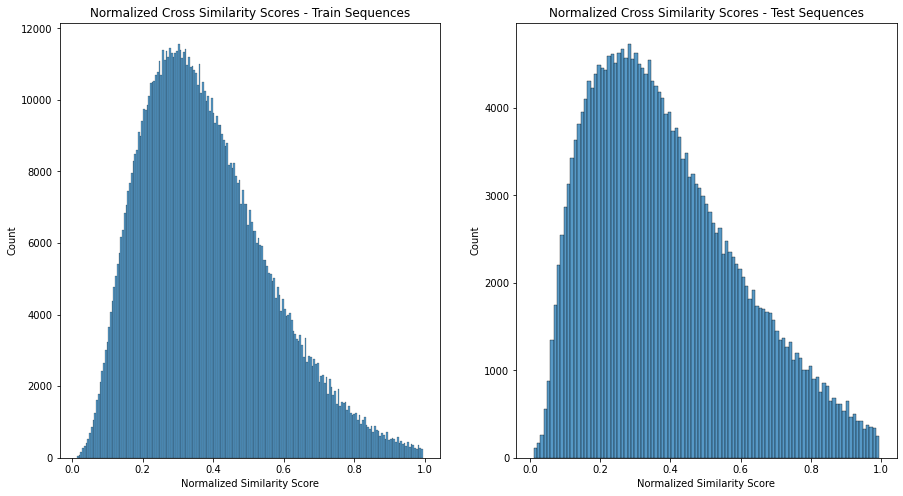

In [130]:
plt.figure(figsize=(15,8))

ax1 = plt.subplot(121)
sns.histplot(norm_arr_tr).set(title='Normalized Cross Similarity Scores - Train Sequences');
ax1.set(xlabel='Normalized Similarity Score', ylabel='Count');

ax2 = plt.subplot(122)
sns.histplot(norm_arr_t).set(title='Normalized Cross Similarity Scores - Test Sequences');
ax2.set(xlabel='Normalized Similarity Score', ylabel='Count');

In [131]:
print("Mean similarity score - Train: ", norm_arr_tr.mean())
print("Mean similarity score - Test: ", norm_arr_t.mean())
print("Maximum similarity score - Train: ", norm_arr_tr.max())
print("Maximum similarity score - Test: ", norm_arr_t.max())

Mean similarity score - Train:  0.38128818839787537
Mean similarity score - Test:  0.3886081306049823
Maximum similarity score - Train:  0.9951456310679612
Maximum similarity score - Test:  0.9954337899543378


It looks like most sequences share only about a third of their amino acid alignments with other sequences, although there are a number of sequences which are very similar to each other.

In [132]:
norm_cross_df_tr.to_csv("../data/dna_binding/train_cross_similarity_norm.csv")
norm_cross_df_t.to_csv("../data/dna_binding/test_cross_similarity_norm.csv")